# Text classification with TREC Dataset
# using **Recurrent Neural Networks**

## Library instalation and importation

In [ ]:
!pip install datasets

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
import time
import seaborn as sns 
import matplotlib.pyplot as plt
from io import StringIO
from IPython.display import display

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix 

## Load dataset

In [2]:
from datasets import load_dataset
df = load_dataset("trec")

  0%|          | 0/2 [00:00<?, ?it/s]

## Function to plot graphs and function to plot confusion matrix

In [3]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
def plot_confusion_matrix(y_true, y_pred, plot_title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'],
           yticklabels=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'],
           title=plot_title, ylabel='Categoria real', xlabel='Categoria predita')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2. else "black")
    fig.tight_layout()
    plt.show()

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    fig, ax = plt.subplots()
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(cm_normalized.shape[1]),
           yticks=np.arange(cm_normalized.shape[0]),
           xticklabels=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'],
           yticklabels=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'],
           title=plot_title, ylabel='Categoria real', xlabel='Categoria predita')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            ax.text(j, i, format(cm_normalized[i, j], '.0%'),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > cm_normalized.max() / 2. else "black")

    fig.tight_layout()
    plt.show()

## Dataset preprocessing

In [5]:
# Preprocess labels
label='coarse_label'
y_true = df['test'][label]
y_test = keras.utils.to_categorical(y_true, 6)
y_train = keras.utils.to_categorical(df['train'][label], 6)

# Create tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((df['train']['text'], y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((df['test']['text'], y_test))

BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create encoder
vocab_size = 8604
encoder = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
encoder.adapt(train_dataset.map(lambda text, label: text))


## Models

In [6]:
vocab_size=8604
# GRU
model0 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
# LSTM
model1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
# LSTM
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=64,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax') 
])
# GRU
model3 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=64,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax') 
])
# 2 GRU
model4 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(vocab_size, 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [7]:
model = model1

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          550656    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                

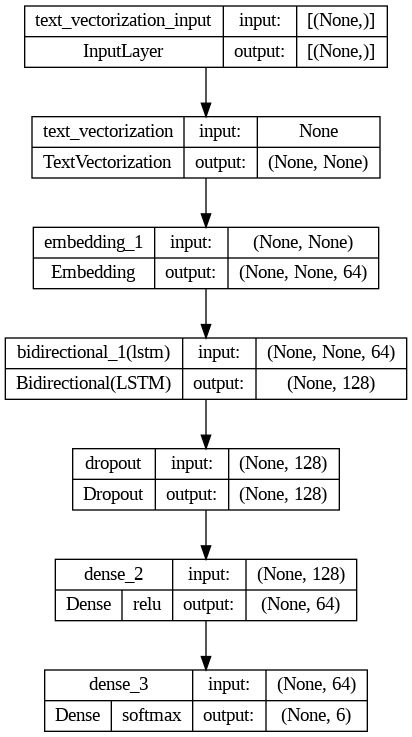

In [9]:
tf.keras.utils.plot_model(
model,to_file="model.png",show_shapes=True,show_dtype=False,show_layer_names=True,
rankdir="TB",expand_nested=True,dpi=96,layer_range=None,show_layer_activations=True)

## Train the model

In [10]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(
  monitor='val_loss',  # Metric to monitor for early stopping
  patience=5,           # Number of epochs with no improvement before stopping
  restore_best_weights=True  # Restores the weights of the best epoch
)

# Train model
st = time.time()
st_p = time.process_time()
history = model.fit(train_dataset, epochs=30,
                    validation_data=test_dataset,
                    validation_steps=8,
                    callbacks=[early_stopping])
et = time.time()
et_p = time.process_time()
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(et-st)))
print('CPU Execution time:', time.strftime("%H:%M:%S", time.gmtime(et_p-st_p)))




Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


86/86 [==============================] - 29s 199ms/step - loss: 1.7772 - accuracy: 0.2638 - val_loss: 1.7662 - val_accuracy: 0.2700
Epoch 2/30
86/86 [==============================] - 7s 85ms/step - loss: 1.7173 - accuracy: 0.3034 - val_loss: 1.7047 - val_accuracy: 0.2800
Epoch 3/30
86/86 [==============================] - 3s 36ms/step - loss: 1.6201 - accuracy: 0.3094 - val_loss: 1.6287 - val_accuracy: 0.3020
Epoch 4/30
86/86 [==============================] - 3s 34ms/step - loss: 1.5362 - accuracy: 0.4101 - val_loss: 1.5312 - val_accuracy: 0.3680
Epoch 5/30
86/86 [==============================] - 3s 33ms/step - loss: 1.3991 - accuracy: 0.4921 - val_loss: 1.3768 - val_accuracy: 0.5480
Epoch 6/30
86/86 [==============================] - 2s 27ms/step - loss: 1.1959 - accuracy: 0.5759 - val_loss: 1.2062 - val_accuracy: 0.6480
Epoch 7/30
86/86 [==============================] - 3s 33ms/step - loss: 0.9941 - accuracy: 0.6471 - val_loss: 1.0700 - val_accuracy: 0.6900
Epoch 8/30
86/86 [====

# Evaluate Model

In [12]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 0s 6ms/step - loss: 0.6202 - accuracy: 0.8440
Test Loss: 0.6201993227005005
Test Accuracy: 0.843999981880188


# Plot of accurcy and loss

Text(0.5, 1.0, 'Loss')

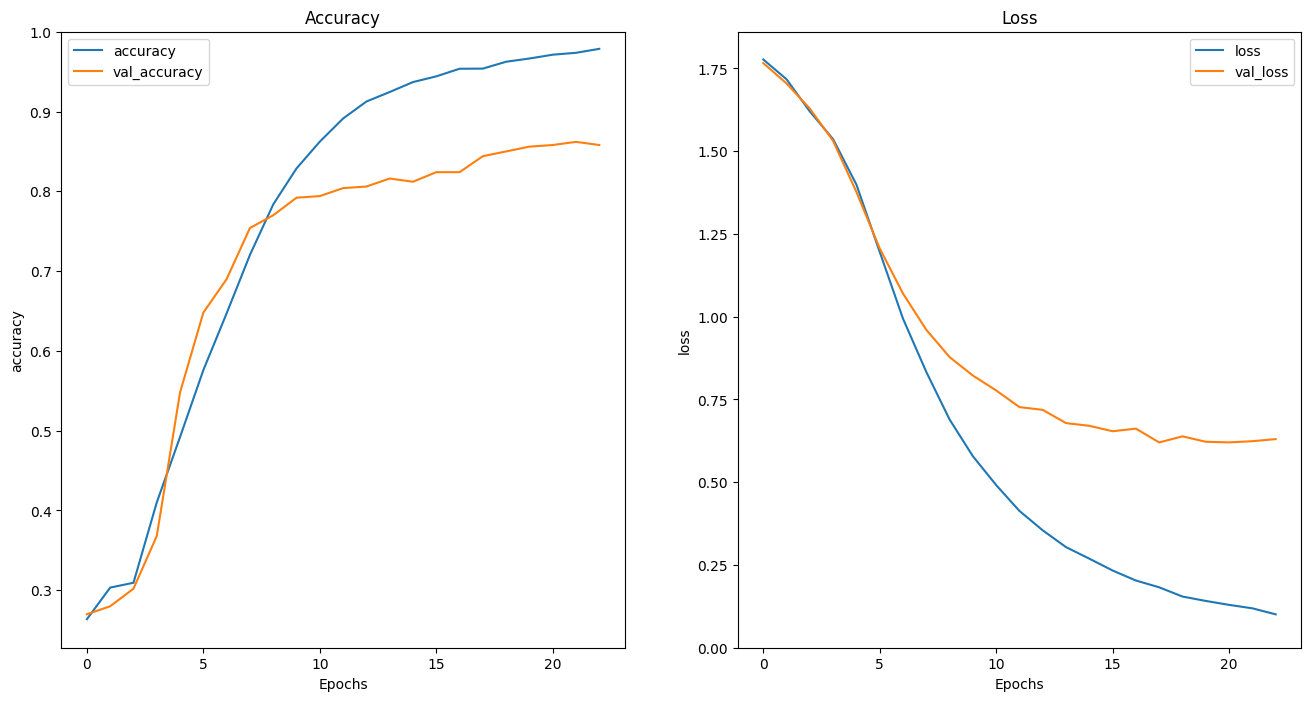

In [13]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.title('Loss')

## Confusion matrix

In [14]:
# Get predicted probabilities for the test data
y_pred_prob = model.predict(df['test']['text'])

# Convert predicted probabilities to predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

16/16 [==============================] - 3s 6ms/step


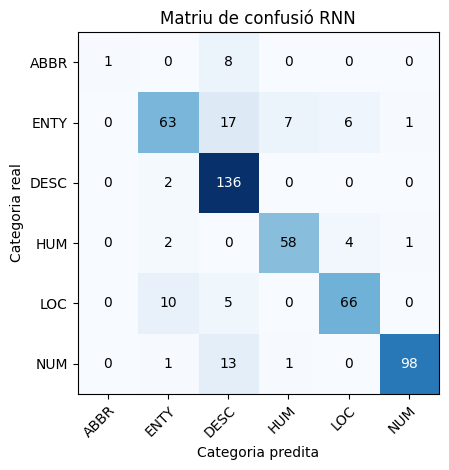

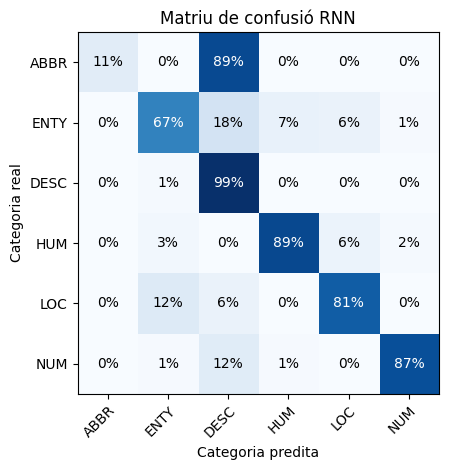

In [15]:
plot_confusion_matrix(y_true, y_pred, "Matriu de confusió RNN")